In [ ]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [ ]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

#레티나 디스플레이로 폰트가 선명하게 표시되도록 합니다.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

!pip install catboost
from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

import folium
from folium import Marker, Icon, CircleMarker

!pip install pdpbox
from pdpbox import pdp, info_plots

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Dataset

In [ ]:
!pip install kaggle 
from google.colab import files 
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minaahayley","key":"2b9a4ddc90c33aadf0ac55ad9e6919df"}'}

In [ ]:
!mkdir -p ~/.kaggle #create folder name Kaggle
!cp kaggle.json ~/.kaggle #copy kaggle.jason into folder Kaggle
!chmod 600 ~/.kaggle/kaggle.json #ignore Permission Warning 

%ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

!unzip competitive-data-science-predict-future-sales.zip

 99% 15.0M/15.1M [00:02<00:00, 13.2MB/s]
100% 15.1M/15.1M [00:02<00:00, 6.21MB/s]
Archive:  competitive-data-science-predict-future-sales.zip
  inflating: item_categories.csv     
  inflating: items.csv               
  inflating: sales_train.csv         
  inflating: sample_submission.csv   
  inflating: shops.csv               
  inflating: test.csv                


In [ ]:
!mkdir -p ~/.kaggle/competitions/predict-future-sales #create folder name Kaggle
!cp item_categories.csv ~/.kaggle/competitions/predict-future-sales #copy into folder Kaggle
!cp items.csv ~/.kaggle/competitions/predict-future-sales
!cp sales_train.csv ~/.kaggle/competitions/predict-future-sales
!cp sample_submission.csv ~/.kaggle/competitions/predict-future-sales
!cp shops.csv ~/.kaggle/competitions/predict-future-sales
!cp test.csv ~/.kaggle/competitions/predict-future-sales

%ls ~/.kaggle/competitions/predict-future-sales

item_categories.csv  sales_train.csv        shops.csv
items.csv            sample_submission.csv  test.csv


In [ ]:
item_cats = pd.read_csv('~/.kaggle/competitions/predict-future-sales/item_categories.csv')
train = pd.read_csv('~/.kaggle/competitions/predict-future-sales/sales_train.csv')
shops = pd.read_csv('~/.kaggle/competitions/predict-future-sales/shops.csv')
items = pd.read_csv('~/.kaggle/competitions/predict-future-sales/items.csv')
sample_submission = pd.read_csv('~/.kaggle/competitions/predict-future-sales/sample_submission.csv')
test = pd.read_csv('~/.kaggle/competitions/predict-future-sales/test.csv')

In [ ]:
print('Train-set : {}'.format(train.shape))
print('Test-set : {}'.format(test.shape))

Train-set : (2935849, 6)
Test-set : (214200, 3)


In [ ]:
train.date_block_num.max()

33

In [ ]:
pd.options.display.float_format = '{:.5f}'.format

train.item_cnt_day.describe()

count   2935849.00000
mean          1.24264
std           2.61883
min         -22.00000
25%           1.00000
50%           1.00000
75%           1.00000
max        2169.00000
Name: item_cnt_day, dtype: float64

In [ ]:
# 상위 25개 
train.item_cnt_day.nlargest(25).values

array([2169., 1000.,  669.,  637.,  624.,  539.,  533.,  512.,  508.,
        504.,  502.,  501.,  500.,  500.,  480.,  412.,  405.,  401.,
        401.,  343.,  325.,  313.,  313.,  300.,  299.])

In [ ]:
display(train.head())
display(test.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00000,1.00000
1,03.01.2013,0,25,2552,899.00000,1.00000
2,05.01.2013,0,25,2552,899.00000,-1.00000
3,06.01.2013,0,25,2554,1709.05000,1.00000
4,15.01.2013,0,25,2555,1099.00000,1.00000


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
# test data에는 있지만 train data에는 없는 아이템 
test_only = test[~test['item_id'].isin(train['item_id'].unique())]['item_id'].unique()
print('test only items:', len(test_only))

test only items: 363


## Preprocessing

In [ ]:
# drop duplicates
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)

False    2935825
True          24
dtype: int64


In [ ]:
# drop shops & items not in test data 
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

train.shape

(1224429, 6)

In [ ]:
train.sample()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2693577,19.06.2015,29,28,13721,229.0,1.0


In [ ]:
from itertools import product 

# create all combinations 
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num', 'shop_id'])
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id', 'item_id'])
all_combi = block_shop_combi.merge(shop_item_combi, on='shop_id', how='inner')

In [ ]:
all_combi.head()

,date_block_num,shop_id,item_id
0,0,5,5037
1,0,5,5320
2,0,5,5233
3,0,5,5232
4,0,5,5268


In [ ]:
# group by monthly 
train_base = all_combi.merge(train, on=['date_block_num', 'shop_id', 'item_id'], how='left')
train_base['item_cnt_day'].fillna(0, inplace=True)
train_grp = train_base.groupby(['date_block_num', 'shop_id', 'item_id'])

In [ ]:
# summary count by month 
train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum', 'count']})).reset_index()
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt', 'item_order']

In [ ]:
print(train_monthly.item_cnt.describe())
print('\n')
print(train_monthly.item_order.describe())

count    7.282800e+06
mean     2.221345e-01
std      3.324564e+00
min     -4.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.253000e+03
Name: item_cnt, dtype: float64


count    7.282800e+06
mean     1.085718e+00
std      7.254517e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.100000e+01
Name: item_order, dtype: float64


In [ ]:
# trim count 
train_monthly['item_cnt'].clip(0, 20, inplace=True)
train_monthly.head()

,date_block_num,shop_id,item_id,item_cnt,item_order
0,0,2,30,0.0,1
1,0,2,31,0.0,1
2,0,2,32,0.0,1
3,0,2,33,1.0,1
4,0,2,38,0.0,1


## Feature creation

### 아이템 그룹 Feature 생성 

In [ ]:
display(items.head())
display(item_cats.head())

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
# pickup first category name
item_grp = item_cats['item_category_name'].apply(lambda x : str(x).split(' ')[0])
item_cats['item_group'] = pd.Categorical(item_grp).codes
items = pd.merge(items, item_cats.loc[:,['item_category_id', 'item_group']], on='item_category_id', how='left')

items.head()

,item_name,item_id,item_category_id,item_group
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,7
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,11
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7
4,***КОРОБКА (СТЕКЛО) D,4,40,7


### 도시 Feature 생성 

In [ ]:
city = shops.shop_name.apply(lambda x : str.replace(x, '!', '')).apply(lambda x : x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes 
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2


### 수치 대표 값들로 Feature 생성 

In [ ]:
# By shop, item 
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':['mean', 'median', 'std'], 'item_order':'mean'}).reset_index()
train_shop.columns = ['shop_id', 'item_id', 'cnt_mean_shop', 'cnt_med_shop', 'cnt_std_shop', 'order_mean_shop']
print(train_shop[['cnt_mean_shop', 'cnt_med_shop', 'cnt_std_shop']].describe())

train_shop.head()

       cnt_mean_shop   cnt_med_shop   cnt_std_shop
count  214200.000000  214200.000000  214200.000000
mean        0.187741       0.054169       0.380878
std         0.608329       0.508886       0.773115
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.029412       0.000000       0.171499
75%         0.147059       0.000000       0.430562
max        20.000000      20.000000      10.054796


,shop_id,item_id,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop
0,2,30,0.117647,0.0,0.327035,1.000000
1,2,31,0.235294,0.0,0.740959,1.088235
2,2,32,0.323529,0.0,0.638207,1.088235
3,2,33,0.323529,0.0,0.534880,1.029412
4,2,38,0.000000,0.0,0.000000,1.000000


In [ ]:
# By shop, item_group 
train_cat_monthly = pd.merge(train_monthly, items, on='item_id', how='left')
grp = train_cat_monthly.groupby(['shop_id', 'item_group'])
train_shop_cat = grp.agg({'item_cnt': 'mean'}).reset_index()
train_shop_cat.columns = ['shop_id', 'item_group', 'cnt_mean_shop_cat']
print(train_shop_cat.loc[:, ['cnt_mean_shop_cat']].describe())

train_shop_cat.head()

       cnt_mean_shop_cat
count         546.000000
mean            0.924991
std             2.172233
min             0.000000
25%             0.029441
50%             0.149099
75%             0.467216
max            13.382353


,shop_id,item_group,cnt_mean_shop_cat
0,2,0,0.000000
1,2,1,0.352157
2,2,3,0.000000
3,2,4,0.196429
4,2,5,0.291689


### 지난 달의 값들을 Feature로 생성 

In [ ]:
# By month,shop,item At previous
train_prev = train_monthly.copy()
train_prev['date_block_num'] = train_prev['date_block_num'] + 1 
train_prev.columns = ['date_block_num','shop_id','item_id','cnt_prev','order_prev']

for i in [2, 12]: 
  train_prev_n = train_monthly.copy()
  train_prev_n['date_block_num'] = train_prev_n['date_block_num'] + i 
  train_prev_n.columns = ['date_block_num', 'shop_id', 'item_id', 'cnt_prev' + str(i), 'order_prev'+str(i)]
  train_prev = pd.merge(train_prev, train_prev_n, on =['date_block_num', 'shop_id', 'item_id'], how='left')

train_prev.head()

,date_block_num,shop_id,item_id,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12
0,1,2,30,0.0,1,NaN,NaN,NaN,NaN
1,1,2,31,0.0,1,NaN,NaN,NaN,NaN
2,1,2,32,0.0,1,NaN,NaN,NaN,NaN
3,1,2,33,1.0,1,NaN,NaN,NaN,NaN
4,1,2,38,0.0,1,NaN,NaN,NaN,NaN


In [ ]:
# By month, shop, item_group At previous 
grp = pd.merge(train_prev, items, on='item_id', how='left').groupby(['date_block_num', 'shop_id', 'item_group'])
train_cat_prev = grp['cnt_prev'].mean().reset_index()
train_cat_prev = train_cat_prev.rename(columns={'cnt_prev':'cnt_prev_cat'})
print(train_cat_prev.loc[:, ['cnt_prev_cat']].describe())

train_cat_prev.head()

       cnt_prev_cat
count  18564.000000
mean       0.924991
std        2.963806
min        0.000000
25%        0.000000
50%        0.095969
75%        0.396336
max       20.000000


,date_block_num,shop_id,item_group,cnt_prev_cat
0,1,2,0,0.000000
1,1,2,1,0.280000
2,1,2,3,0.000000
3,1,2,4,0.000000
4,1,2,5,0.100186


### 이동평균값과 MACD, Signal Feature 생성 

In [ ]:
train_piv = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt', aggfunc=np.sum, fill_value=0)
train_piv = train_piv.reset_index()
train_piv.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,2,2,0,2,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,1,0
4,2,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Moving Average Convergence Divergence : 2개의 지수이평선 간의 거리를 수치화 
# MACD = 12일 EMA - 26일 EMA / 단기 EMA - 장기 EMA 
col = np.arange(34)
pivT = train_piv[col].T
ema_s = pivT.ewm(span=4).mean().T
ema_m = pivT.ewm(span=12).mean().T
ema_l = pivT.ewm(span=26).mean().T 
macd = ema_s - ema_l 
sig = macd.ewm(span=9).mean() # 시그널선 : MACD의 9일 지수이평선 

ema_list = [] 
for c in col: 
  sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']], 
                      pd.DataFrame(ema_s.loc[:, c]).rename(columns={c:'cnt_ema_s_prev'}),
                      pd.DataFrame(ema_m.loc[:, c]).rename(columns={c:'cnt_ema_m_prev'}),
                      pd.DataFrame(ema_l.loc[:, c]).rename(columns={c:'cnt_ema_l_prev'}),
                      pd.DataFrame(macd.loc[:, c]).rename(columns={c:'cnt_macd_prev'}),
                      pd.DataFrame(sig.loc[:, c]).rename(columns={c:'cnt_sig_prev'})], axis=1) 
  sub_ema['date_block_num'] = c+1
  ema_list.append(sub_ema)

train_ema_prev = pd.concat(ema_list) 
train_ema_prev.head()

,shop_id,item_id,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,date_block_num
0,2,30,0.0,0.0,0.0,0.0,0.0,1
1,2,31,0.0,0.0,0.0,0.0,0.0,1
2,2,32,0.0,0.0,0.0,0.0,0.0,1
3,2,33,1.0,1.0,1.0,0.0,0.0,1
4,2,38,0.0,0.0,0.0,0.0,0.0,1


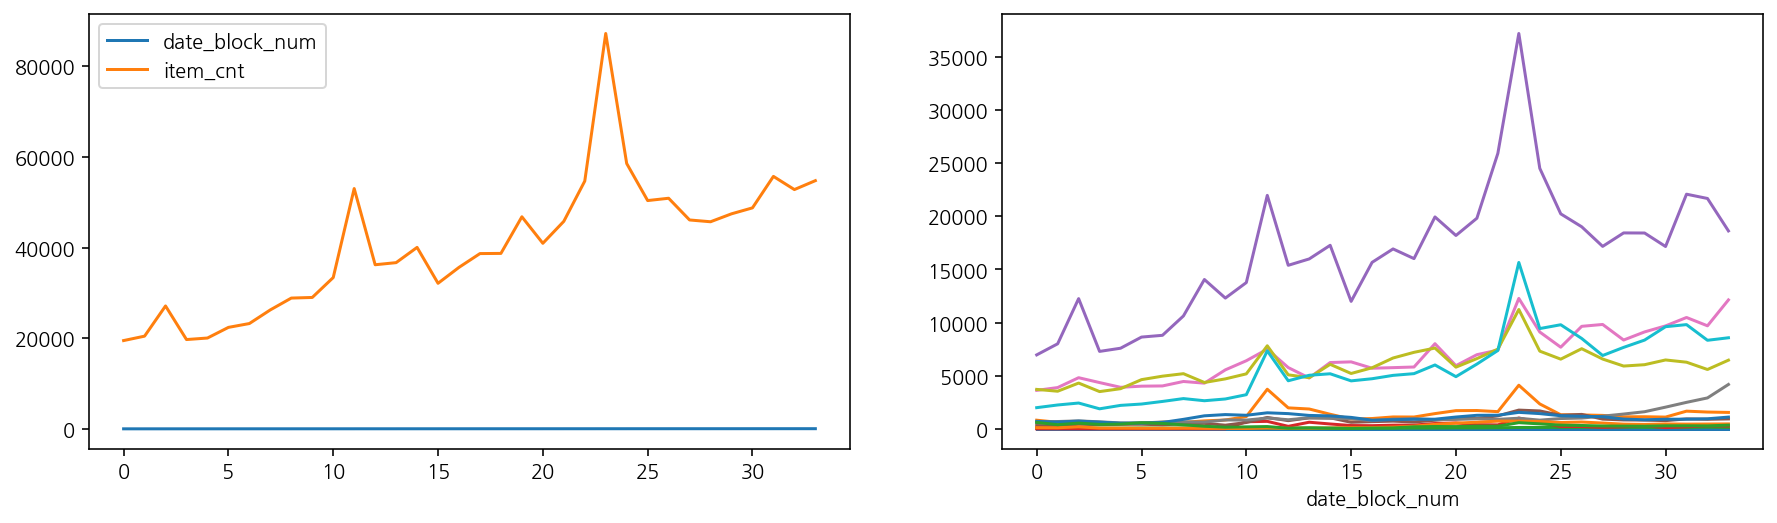

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4)) 

train_monthly.groupby('date_block_num')['item_cnt'].sum().reset_index().plot(ax=ax[0])
train_cat_monthly.pivot_table(index=['date_block_num'], columns='item_group', values='item_cnt', aggfunc=np.sum, fill_value=0).plot(ax=ax[1], legend=False)

### 비어있는 가격 예측 

In [ ]:
# Price mean by month, shop, item 
train_price = train_grp['item_price'].mean().reset_index() 
price = train_price[~train_price['item_price'].isnull()]

# last price by shop, item 
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop('date_block_num', axis=1)

# null price by shop, item 
uitem = price['item_id'].unique()
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1)

print(pred_price_set.shape)
pred_price_set.head()

(16128, 2)


,shop_id,item_id
1,5,5320
4,5,5268
45,5,5826
64,5,3538
65,5,3571


In [ ]:
from sklearn import ensemble, metrics 

if len(pred_price_set) > 0: 
  train_price_set = pd.merge(price, items, on='item_id', how='inner') 
  pred_price_set = pd.merge(pred_price_set, items, on='item_id', how='inner').drop('item_name', axis=1) 
  
  reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
  reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price'])
  pred_price_set['item_price'] = reg.predict(pred_price_set)

test_price = pd.concat([last_price, pred_price_set], join='inner')
test_price.head()

,shop_id,item_id,item_price
209,2,1204,299.0
211,2,1224,399.0
219,2,1247,299.0
826,2,3656,299.0
1064,2,4531,279.0


### 할인율 계산 

In [ ]:
price_max = price.groupby('item_id')['item_price'].max().reset_index()
price_max.rename(columns={'item_price': 'item_max_price'}, inplace=True) 
price_max.head()

,item_id,item_max_price
0,30,399.0
1,31,699.0
2,32,349.0
3,33,499.0
4,38,2399.0


In [ ]:
train_price_a = pd.merge(price, price_max, on='item_id', how='left')
train_price_a['discount_rate'] = 1 - (train_price_a['item_price']/train_price_a['item_max_price']) 
train_price_a.drop('item_max_price', axis=1, inplace=True)
train_price_a.head()

,date_block_num,shop_id,item_id,item_price,discount_rate
0,0,2,33,499.0,0.000000
1,0,2,482,3300.0,0.000000
2,0,2,491,600.0,0.000000
3,0,2,839,3300.0,0.000000
4,0,2,1007,449.0,0.625521


In [ ]:
test_price_a = pd.merge(test_price, price_max, on='item_id', how='left')
test_price_a.loc[test_price_a['item_max_price'].isnull(), 'item_max_price'] = test_price_a['item_price'] 
test_price_a['discount_rate'] = 1 - ( test_price_a['item_price']/test_price_a['item_max_price'])
test_price_a.drop('item_max_price', axis=1, inplace=True)
test_price_a.head()

,shop_id,item_id,item_price,discount_rate
0,2,1204,299.0,0.000000
1,2,1224,399.0,0.111359
2,2,1247,299.0,0.000000
3,2,3656,299.0,0.143266
4,2,4531,279.0,0.066890


## Data preparation

In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def mergeFeature(df): 
  df = pd.merge(df, items, on='item_id', how='left').drop('item_group', axis=1)
  df = pd.merge(df, item_cats, on='item_category_id', how='left')
  df = pd.merge(df, shops, on='shop_id', how='left')
  df = pd.merge(df, train_shop, on=['shop_id', 'item_id'], how='left')
  df = pd.merge(df, train_shop_cat, on=['shop_id', 'item_group'], how='left')
  df = pd.merge(df, train_prev, on=['date_block_num','shop_id','item_id'], how='left') 
  df = pd.merge(df, train_cat_prev, on=['date_block_num','shop_id','item_group'], how='left')
  df = pd.merge(df, train_ema_prev, on=['date_block_num','shop_id','item_id'], how='left')
  
  df['month'] = df['date_block_num'] % 12 
  days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
  df['days'] = df['month'].map(days).astype(np.int8)

  df.drop(['shop_id', 'shop_name', 'item_id', 'item_name', 'item_category_id', 'item_category_name', 'item_group'], axis=1, inplace=True)
  df.fillna(0.0, inplace=True)
  return reduce_mem_usage(df)

In [ ]:
display(train_monthly.sample())
display(train_price_a.sample() )

,date_block_num,shop_id,item_id,item_cnt,item_order
3170984,14,49,16159,0.0,1


,date_block_num,shop_id,item_id,item_price,discount_rate
557157,32,28,19602,169.0,0.0


In [ ]:
# 전 기간의 모든 데이터셋을 사용하지 않고, 초반의 12개월 후의 데이터만 사용 
# 왜냐하면 training feature에는 12개월 전의 값들(order_prev12)이 들어있다 
train_set = train_monthly[train_monthly['date_block_num'] >= 12]
train_set = pd.merge(train_set, train_price_a, on=['date_block_num', 'shop_id', 'item_id'], how='left')
train_set = mergeFeature(train_set)

Memory usage of dataframe is 871.85 MB --> 404.47 MB (Decreased by 53.6%)


In [ ]:
train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column
X_train = train_set.drop('item_cnt', axis=1)
y_train = train_set['item_cnt'].clip(0., 20.)
X_train.head()

,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,12,0.0,0.000000,0,0.117647,0.0,0.327035,1.000000,0.038727,0.0,1,0.0,1.0,0.0,1.0,0.039588,0.022743,0.104790,0.138890,-0.116147,-0.116147,0,31,1
1,12,0.0,0.000000,0,0.235294,0.0,0.740959,1.088235,0.038727,0.0,1,0.0,1.0,0.0,1.0,0.039588,0.020469,0.220062,0.355486,-0.335018,-0.237742,0,31,1
2,12,119.0,0.659026,0,0.323529,0.0,0.638207,1.088235,0.038727,0.0,1,0.0,1.0,0.0,1.0,0.039588,0.000000,0.000000,0.000000,0.000000,-0.140307,0,31,1
3,12,199.0,0.601202,0,0.323529,0.0,0.534880,1.029412,0.038727,1.0,1,2.0,2.0,1.0,1.0,0.039588,0.883374,0.506989,0.403090,0.480284,0.069921,0,31,1
4,12,0.0,0.000000,0,0.000000,0.0,0.000000,1.000000,0.038727,0.0,1,0.0,1.0,0.0,1.0,0.039588,0.000000,0.000000,0.000000,0.000000,0.049121,0,31,1


In [ ]:
test_set = test.copy()
test_set['date_block_num'] = 34 

test_set = pd.merge(test_set, test_price_a, on=['shop_id', 'item_id'], how='left')
test_set = mergeFeature(test_set)

Memory usage of dataframe is 38.00 MB --> 18.18 MB (Decreased by 52.2%)


In [ ]:
test_set.sample()

,ID,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days
32314,32314,34,1469.0,0.412165,6,0.205882,0.0,0.769865,1.058824,0.158491,0.0,1,0.0,1.0,0.0,1.0,0.176252,0.000009,0.012995,0.069315,-0.069306,-0.032347,10,30


In [ ]:
test_set['item_order'] = test_set['cnt_ema_s_prev'] #order_prev
test_set.loc[test_set['item_order']==0, 'item_order'] = 1 

X_test = test_set.drop('ID', axis=1)
X_test.head()

,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,34,749.500000,0.711620,3,0.382353,0.0,0.739152,1.117647,0.274392,0.0,1,1.0,1.0,1.0,1.0,0.377551,0.856217,0.870737,0.673720,0.182497,-0.211641,10,30,0.856217
1,34,304.310272,0.000000,3,0.000000,0.0,0.000000,1.000000,0.093711,0.0,1,0.0,1.0,0.0,1.0,0.103647,0.000000,0.000000,0.000000,0.000000,-0.216406,10,30,1.000000
2,34,1199.000000,0.000000,3,0.294118,0.0,0.798841,1.117647,0.274392,1.0,1,3.0,3.0,0.0,1.0,0.377551,1.460992,1.015923,0.651031,0.809961,0.146857,10,30,1.460992
3,34,599.000000,0.500417,3,0.029412,0.0,0.171499,1.000000,0.274392,0.0,1,0.0,1.0,0.0,1.0,0.377551,0.144000,0.110528,0.068511,0.075489,-0.018919,10,30,0.144000
4,34,2221.775391,0.000000,3,0.000000,0.0,0.000000,1.000000,0.274392,0.0,1,0.0,1.0,0.0,1.0,0.377551,0.000000,0.000000,0.000000,0.000000,-0.033769,10,30,1.000000


In [ ]:
assert(X_train.columns.isin(X_test.columns).all())

## Predict

In [ ]:
from sklearn import linear_model, preprocessing 
from sklearn.model_selection import GroupKFold 
import lightgbm as lgb 

params = {'learning_rate' : 0.05,
          'objective' : 'regression',
          'metric' : 'rmse',
          'num_leaves':64, 
          'verbose' : 1,
          'random_state': 42,
          'bagging_fraction':1, # 각각 iteration 에 사용되는 데이터의 일부를 지정하는데, 일반적으로 훈련 속도를 높이거나, 과적합을 피할때 사용한다.
          'feature_fraction':1} # used when your boosting is random forest. 
          # 즉, 랜덤 포레스트 일 경우에 사용. 
          # 0.8 feature fraction은 LightGBM이 Tree를 만들 때 각각 iteration 반복에서 파라미터 중에서 80%를 랜덤으로 선택.

folds = GroupKFold(n_splits=6)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(X_train, y_train, X_train['date_block_num'])):
  trn_x, trn_y = X_train.iloc[trn_], y_train[trn_]
  val_x, val_y = X_train.iloc[val_], y_train[val_]

  reg = lgb.LGBMRegressor(**params, n_estimators=3000)
  reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500) 

  oof_preds[val_] = reg.predict(val_x.values, num_iteration=reg.best_iteration_) 
  sub_preds += reg.predict(X_test.values, num_iteration=reg.best_iteration_) / folds.n_splits

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.209647
[1000]	valid_0's rmse: 0.207681
Early stopping, best iteration is:
[1018]	valid_0's rmse: 0.207633
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.206711
[1000]	valid_0's rmse: 0.205003
Early stopping, best iteration is:
[1294]	valid_0's rmse: 0.20464
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.208489
[1000]	valid_0's rmse: 0.205751
Early stopping, best iteration is:
[1275]	valid_0's rmse: 0.20516
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.186031
Early stopping, best iteration is:
[607]	valid_0's rmse: 0.185691
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.15861
Early stopping, best iteration is:
[463]	valid_0's rmse: 0.158591
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.186485
Early stopping, 

In [ ]:
pred_cnt = sub_preds

In [ ]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, oof_preds.clip(0.,20.))))

RMSE: 0.19348729089786726


### 모델 학습에 있어 중요한 피쳐는 무엇인가?! 

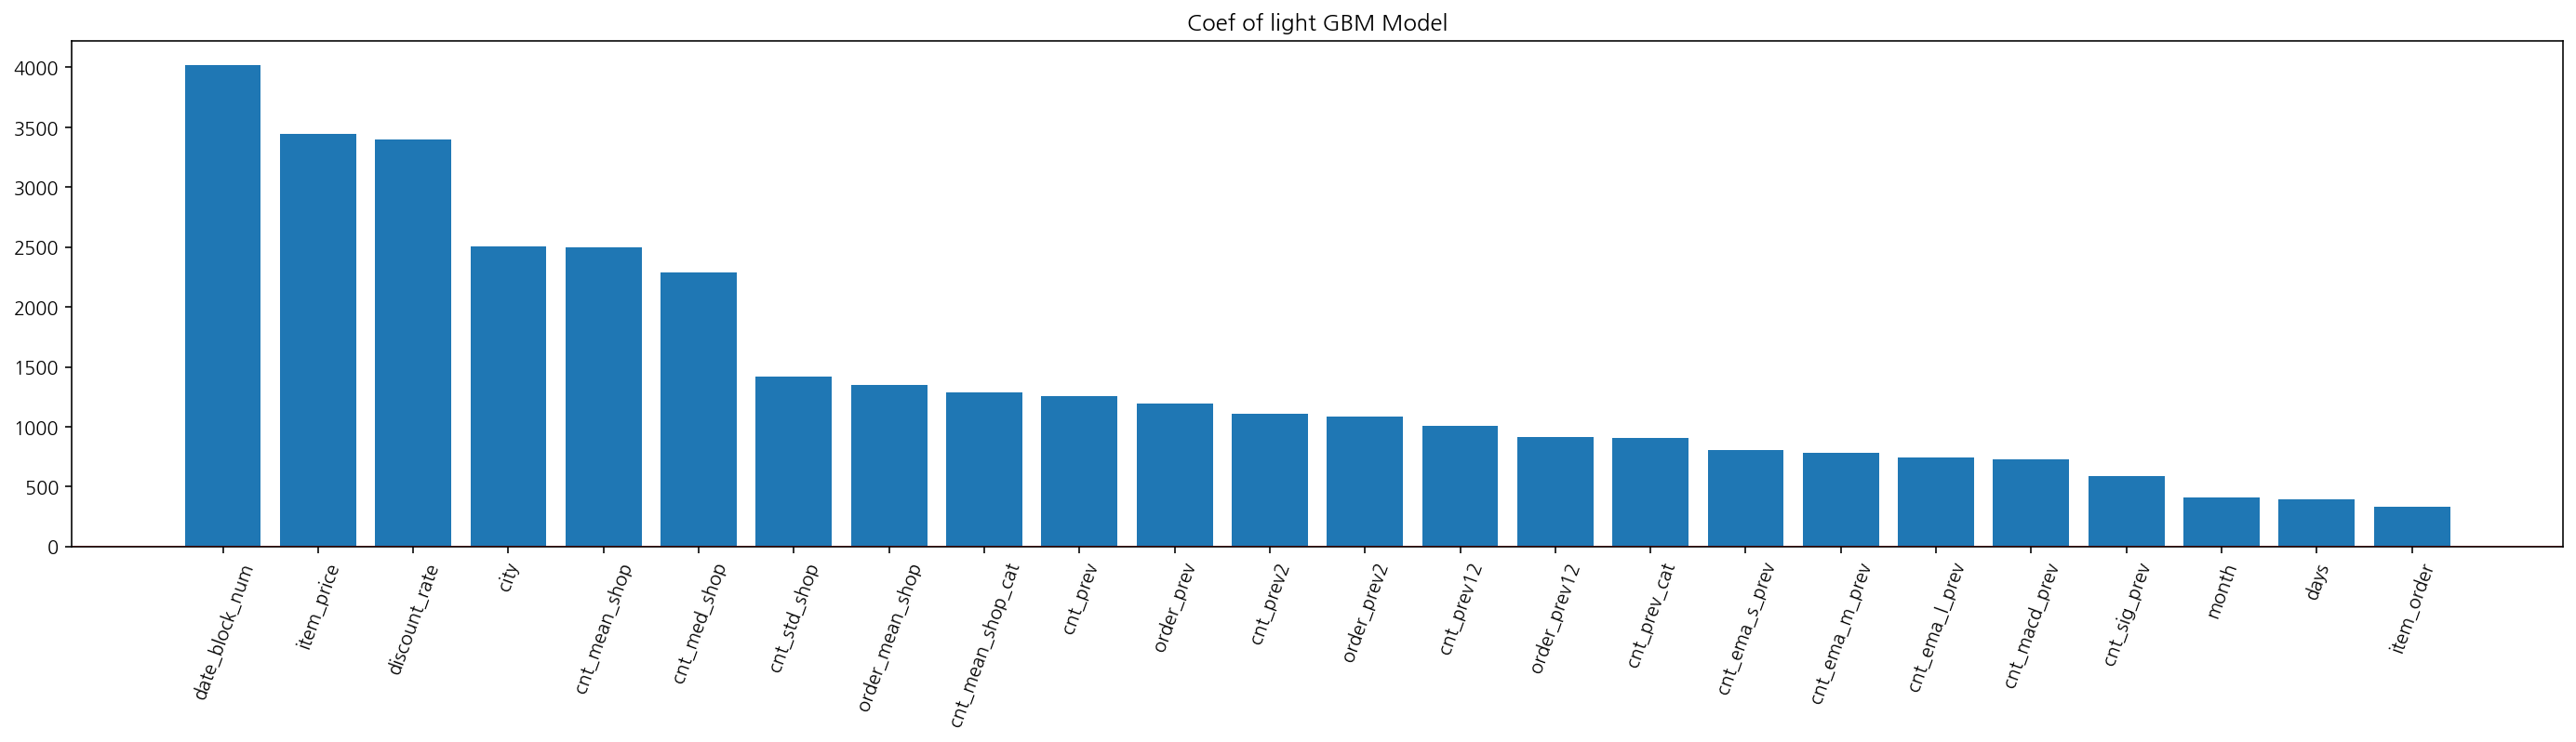

In [ ]:
plt.figure(figsize=(24,5))

# lgbm의 Feature Importances를 barplot으로 그린다.
plt.bar(X_train.columns, reg.feature_importances_[np.argsort(reg.feature_importances_)][::-1])

# y=0인 horizental한 선을 그린다.
plt.axhline(y=0, color='r', linestyle='-')

plt.xticks(rotation=70)
plt.title("Coef of light GBM Model");

## Submit

In [ ]:
result = pd.DataFrame({
    'ID' : test['ID'], 
    'item_cnt_month' : pred_cnt.clip(0., 20.)
})
result.to_csv('submission.csv', index=False)